# Using Outcomes of At-Bats to determine Wins and Hitting Improvements

Rather than directly linking a team's terminal pitch counts to a team's predicted win percentage, we now look at a more direct route using the specific outcomes of those same at-bats.  Despite the flaws of the Pythagorean Expectation model, we will still be using this framework to calculate the win percentages and determine optimal improvements for the team.

Fundamentally, using terminal pitch counts to approximate a team's runs scored, and subsequently win percentage, uses league averages for converting a particular pitch count into some outcome.  As an example, over the 10 seasons in question, 4% of at-bats ending in 3-0 counts result in an out, and 93% end in a walk.  Some teams may be very aggressive and try to take advantage of this batter-favored count, which would reduce the frequency of walks in this count.  As a result, some teams might average significantly higher or lower runs from the 3-0 count.  In previous work, we attempted to use clustering and mixture models to separate teams with these different strategies.  However, since every team's at-bats are spread through their entire lineup of players with different skillsets and tendencies, any clustering of teams ended up being washed out by the Central Limit Theorem, having only one distinguishable strategy.

For the same reason, using these outcome statistics directly will not lead to significant clustering between teams.  But using them in order to approximate a team's runs scored will naturally improve the model, capturing more of the variation in the data.  We note that even using the outcomes of at-bats, we still rely on league averages to account for how many runs a team will score given a certain outcome.  The problem can be written as a series of transformation:
\begin{equation}
\text{Runs Scored} = (\text{Runs for each Outcome})_i * (\text{Outcomes at Pitch Count})_j * (\text{ABs at each Pitch Counts})_k,
\end{equation}
where each step $i,j,k$ can be decided as either league average or team specific.  Further subdivisions can also be done to add more context of a team's performance.  Each choice of a team specific value will increase the model's ability to incorporate variation at the potential cost of overfitting.  The potential issue of overfitting can be eliminated by claiming the value of each outcome does not depend on which terminal pitch count it came from.  As a result, the number of free parameters is restricted to the $N_\text{outcomes}$ rather than $N_\text{outcomes} \times N_\text{counts}$.

In doing so, the model of win percentage does not directly fit pitch counts to win percentage, so the extra complexity of reducing the model parameters is shifted to relating pitch counts to outcomes and thus win percentage.  We will consider how frequently each pitch count leads to the different outcomes, and in turn, how many more wins the team should expect.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from TeamData import *
import random

# Import and arrange all data needed for the linear models
path_home_outcomes = ''
path_away_outcomes = ''

outcomes_home = pd.read_csv(path_home_outcomes, index_col=[0,1])
outcomes_away = pd.read_csv(path_away_outcomes, index_col=[0,1])


path_ra = ''
runs_records = os.listdir(path_ra)

team_ra = pd.DataFrame()

for file in runs_records:
    year = file[-4:]
    cur_year_records = pd.read_csv(path_ra+file, index_col=[0])
    cur_year_records['Year'] = int(year)
    team_ra = pd.concat([team_ra, cur_year_records])
    
team_ra.set_index(['Year', team_ra.index],inplace = True)
    

path_wl = ''
wl_records = os.listdir(path_wl)

team_wl = pd.DataFrame()

for file in wl_records:
    year = file[-4:]
    cur_year_records = pd.read_csv(path_wl+file, index_col=[0])
    cur_year_records['Year'] = int(year)
    team_wl = pd.concat([team_wl, cur_year_records])
    
team_wl.set_index(['Year', team_wl.index],inplace = True)
team_wl['Home W%'] = team_wl['Home_Win']/(team_wl['Home_Win']+team_wl['Home_Loss'])
team_wl['Away W%'] = team_wl['Away_Win']/(team_wl['Away_Win']+team_wl['Away_Loss'])
    
home_data = pd.concat([outcomes_home, team_ra[['Home Runs For','Home Runs Against']], team_wl['Home W%']],axis=1).rename(columns={'Home Runs For':'RF','Home Runs Against':'RA', 'Home W%':'W%'})
away_data = pd.concat([outcomes_away, team_ra[['Away Runs For','Away Runs Against']], team_wl['Away W%']],axis=1).rename(columns={'Away Runs For':'RF','Away Runs Against':'RA', 'Away W%':'W%'})

### Linear Model to Runs For

Using a Pythagorean Expectation to relate runs for and runs allowed to a theoretical win percentage inherently has some problems, as explored in another Notebook.  Here, we quickly show that using a team's direct hitting stats can provide a very accurate approximation of the team's runs scored.  There remains some unexplained variation in the data however due to some variables not included, such as runners left on base, which hint at the overall importance of ordering within the game.

We will use the following outcomes in the model: Strikeouts, Outs (excluding strikeouts), Walks (including hit-by-pitch), Singles, Doubles, Triples, and Home Runs.  Strikeouts are separated from other outs because other outs have the ability to advance runners on base, while strikeouts generally do not.

Trained R^2: 0.9131886472369715
Test R^2: 0.9130736649633496
Error Measures (Train, Test)
MAE: 11.75, 11.97
MSE: 224.44, 248.85
RMSE: 14.98, 15.77
StD of RF: 51.56


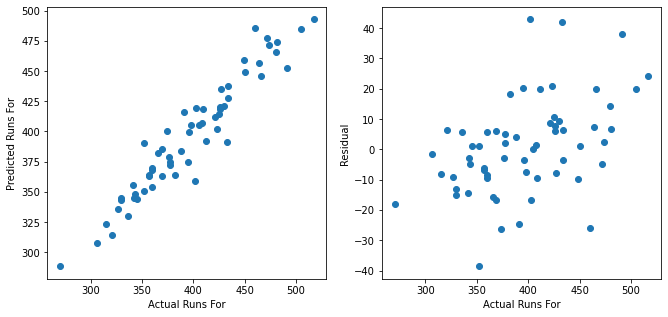

In [2]:
data = home_data # Home or away data that we will model runs scored
model_cols = ['K', 'O', 'W', 'S', 'D', 'T', 'R'] # Order the independent variable to pull out relative values from the fit

# Exclude teams with abnormally high Runs For
# In this case, RF > 600 represents an outlier 4 standard deviations away from the mean
X = data[model_cols][data['RF']<600]
y = data['RF'][data['RF']<600]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_regr = LinearRegression().fit(X_train, y_train)

print('Trained R^2:',lin_regr.score(X_train,y_train))
print('Test R^2:', lin_regr.score(X_test,y_test))


y_pred = lin_regr.predict(X_test)
y_pred_train = lin_regr.predict(X_train)

print('Error Measures (Train, Test)')
print('MAE: {:.2f}, {:.2f}'.format(metrics.mean_absolute_error(y_train, y_pred_train),metrics.mean_absolute_error(y_test, y_pred)))
print('MSE: {:.2f}, {:.2f}'.format(metrics.mean_squared_error(y_train, y_pred_train),metrics.mean_squared_error(y_test, y_pred)))
print('RMSE: {:.2f}, {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('StD of RF: {:.2f}'.format(y.std()))

fig, ax = plt.subplots(1,2,figsize=(11,5))
ax[0].scatter(y_test, y_pred)
ax[0].set_xlabel('Actual Runs For')
ax[0].set_ylabel('Predicted Runs For')
ax[1].scatter(y_test, (y_test-y_pred))
ax[1].set_xlabel('Actual Runs For')
ax[1].set_ylabel('Residual')
plt.show()

### Linear Model for Win Percentage

Given how well the data at hand can model a team's runs scored, we expect that the Pythagorean Expectation will strongly approximate the models previously explored.  Nevertheless, it is important to extract the team's win percentage to give proper estimate of how much each change in strategy will effect wins.  We use the same outcomes as before with the addition of Runs Against stat from previous work.

Explicitly, the model we are considering can be written as
\begin{equation}
\frac{\gamma}{4}(\text{Runs For}) + \frac{2 - \gamma}{4}(\text{Runs Against}) \approx (\text{Runs Against})\times W\%
\end{equation}

Home:
Trained R^2: 0.7484393191654712
Test R^2: 0.7124492355071694

Away
Trained R^2: 0.6350201389331265
Test R^2: 0.6807818163366912

Error Measures (Train, Test)
MAE: 11.57, 12.65
MSE: 220.51, 250.76
RMSE: 14.85, 15.84
StD of RF: 25.35


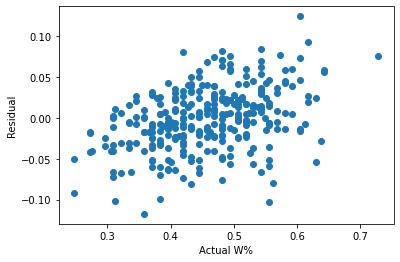

In [3]:
# The dependent variable we will model is the product of Runs Against and Win %
home_data['RAxW%'] = home_data['RA']*home_data['W%']
away_data['RAxW%'] = away_data['RA']*away_data['W%']

# Order the independent variable to pull out relative values from the fit
model_cols = ['K', 'O', 'W', 'S', 'D', 'T', 'R', 'RA']

# Linear Regression for Home Data
data = home_data
X = data[model_cols][data['RF']<600]
y = data['RAxW%'][data['RF']<600]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lin_regr_home = LinearRegression().fit(X_train, y_train)

print('Home:')
print('Trained R^2:',lin_regr_home.score(X_train,y_train))
print('Test R^2:', lin_regr_home.score(X_test,y_test))

print()

# Linear Regression for Away Data
data = away_data
X = data[model_cols][data['RF']<600]
y = data['RAxW%'][data['RF']<600]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_regr_away = LinearRegression().fit(X_train, y_train)

print('Away')
print('Trained R^2:',lin_regr_away.score(X_train,y_train))
print('Test R^2:', lin_regr_away.score(X_test,y_test))
print()



# Show additional statistics on the away hit
y_pred = lin_regr_away.predict(X_test)
y_pred_train = lin_regr_away.predict(X_train)

print('Error Measures (Train, Test)')
print('MAE: {:.2f}, {:.2f}'.format(metrics.mean_absolute_error(y_train, y_pred_train),metrics.mean_absolute_error(y_test, y_pred)))
print('MSE: {:.2f}, {:.2f}'.format(metrics.mean_squared_error(y_train, y_pred_train),metrics.mean_squared_error(y_test, y_pred)))
print('RMSE: {:.2f}, {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('StD of RF: {:.2f}'.format(y.std()))

plt.scatter(y/X['RA'], (y-lin_regr_away.predict(X))/X['RA'])
plt.xlabel('Actual W%')
plt.ylabel('Residual')
plt.show()

## Strategy Adjustments

In order to calculate the optimal modification to a team's hitting strategy, we must relate a team's terminal pitch counts to the outcomes.  For a the team in question, we use the at-bat level data to extract the terminal pitch count and outcome of each at-bat.  The resulting matrix (rows corresponding to the count (i,j), and columns to each outcome of interest) will be labelled $\mathcal{O}$.  Then, the resulting outcomes of some particular modification to the batting strategy can be written as the product of the modified terminal pitch count vector and $\mathcal{O}$:
\begin{equation}
\Delta\text{Outcomes} = \Delta\text{Counts}^T \mathcal{O}.
\end{equation}
The new vector of outcomes can then be fed into the linear model for win probability to extract each modification's impact on the team's wins, and thus quickly find the optimal change in strategy.  The only thing that remains is to calculate the change in terminal pitch counts.


### Modifying a percentage of each terminal pitch count

This model for adjusting strategies builds upon the model used in StrategyAdjustment Notebook.  This method seeks to increase (aggressive change) or decrease (patient change) a team's at-bats at a particular pitch count based on a percentage of at-bats that reach this count.  Written explicitly, the model we are looking at is
\begin{equation}
\Delta\text{Count}(i,j) = x \text{Count}(i,j)T\cdot\vec{B},
\end{equation}
where x is the percentage change of the (i,j) count, $\vec{B}$ is a basis vector for change one terminal pitch count at a time, and $T$ is the general transformation matrix relating at-bats to one another, keeping the total number of at-bats fixed.  Essentially, the matrix $T$ describes where the extra at-bats end up when we reduce the number of at-bats ending at some count (i,j), or where the at-bats come from when adding to a count.

In this Notebook, we calculate $T$ by again looking at each at-bat of a particular team.  For each at-bat, we record the pitch counts reached and the terminal pitch count.  Recording this way allows us to directly calculate the conditional probability $P((i,j)|(b,s))$, the probability of a certain terminal pitch (i, j) count once a particular non-terminal count (b, s) is reached.  The matrix $T$ can then be written in terms of these conditional probabilities as
\begin{equation}
T = P(ij|bs) - \mathbb{1} = 
\begin{bmatrix}
-1 & 0 & 0 & \dots\\
P(10|00) & -1 & 0\\
P(20|00) & P(20|10) & -1 &\\
\vdots & & & \ddots
\end{bmatrix}.
\end{equation}
A further explanation of this matrix can be found in the StrategyAdjustment Notebook.

In [4]:
# Function that takes the team's data and calculates the optimal strategy adjustment
def optimize_strat_adjust(team_class, team_data, scale, regr, ha):
    x = scale
    team = team_class.team
    year = team_class.year
    
    transform = team_class.transformation_matrix()

    team_pitch_counts = team_class.counts[[0,10,20,30,1,11,21,31,2,12,22,32]] # Order columns for matrix multiplication
    
    # Calculate the outcomes for each modified strategy
    transform_value = team_pitch_counts.to_numpy() + transform.T.multiply(team_pitch_counts.to_numpy(),axis=0)*x
    outcome_at_count = team_class.outcomes.groupby('Count')['Outcome'].value_counts().unstack().fillna(0)[['K', 'O', 'W', 'S', 'D', 'T', 'R']]
    outcome_at_count = outcome_at_count.T[[0,10,20,30,1,11,21,31,2,12,22,32]].T
    outcome_frac = outcome_at_count.div(outcome_at_count.sum(axis=1),axis=0)
    outcome_frac.index = [j+i for i in ['0','1','2'] for j in ['0','1','2','3']]
    strategies = transform_value.dot(outcome_frac)
    
    # For each modified strategy, predict number of wins and find the optimal modification
    strategies['RA'] = team_data.loc[(int(year), team), 'RA']
    predicted_wins = regr.predict(strategies)/strategies['RA']
    max_change_index = np.argmax(np.abs(predicted_wins - predicted_wins[-1]))
    win_change = np.max(np.abs(predicted_wins - predicted_wins[-1]))*81    
    is_patient = ((predicted_wins - predicted_wins[-1])[max_change_index] > 0)
    patient_or_aggressive = 'Patient'*int(is_patient) + 'Aggressive'*(1-int(is_patient))
    
    ha_str = 'Home'*(ha==1) + 'Away'*(ha==0) # Home or away
    print('Team: '+year+' '+team)
    print('Change on Pitch Count: '+ predicted_wins.index[max_change_index])
    print(x,patient_or_aggressive)
    print('Actual {} Wins: {:.0f}'.format(ha_str, 81*team_data.loc[(int(year), team)]['W%']))
    print('Original Predicted {} Wins: {:.2f}'.format(ha_str, 81*predicted_wins[-1]))
    print('Improved Predicted {} Wins: {:.2f}'.format(ha_str, 81*predicted_wins[-1]+win_change))
    print('Improvement: {:.2f}'.format(win_change))
    
    #return [predicted_wins, max_change_index, patient_or_aggressive, win_change]

In [5]:
path_home = ''
path_away = ''

test_df = pd.DataFrame()

# Choose some team to modify the strategy
random_team_str = random.choice(os.listdir(path_home))
year = random_team_str[:4]
team = random_team_str[4:7]

home_csv = pd.read_csv(path_home+random_team_str,index_col=[0,1])
away_csv = pd.read_csv(path_away+random_team_str[:-4]+'Away',index_col=[0,1])
team_home = Team(team, year, home_csv, 1)
team_away = Team(team, year, away_csv, 0)

# Find the optimal strategy modification for both home and away data
optimize_strat_adjust(team_home, home_data, 0.01, lin_regr_home, 1)
print()
optimize_strat_adjust(team_away, away_data, 0.01, lin_regr_away, 0)

Team: 2006 DET
Change on Pitch Count: 22
0.01 Patient
Actual Home Wins: 46
Original Predicted Home Wins: 42.54
Improved Predicted Home Wins: 42.63
Improvement: 0.09

Team: 2006 DET
Change on Pitch Count: 22
0.01 Patient
Actual Away Wins: 49
Original Predicted Away Wins: 50.14
Improved Predicted Away Wins: 50.21
Improvement: 0.07


#### Shortcomings

One main advantage of this method in comparison to the previous files is the accuracy of how pitch counts relate to one another and how those changes will influence a team's runs scored and thus their wins.  However, this requires significantly more computing power for nearly the same improvement.

Of note, adding in the team's actual outcomes at each at-bat forces nearly every team to take a patient approach on 2-2 pitch counts.  One reason for this is that 2-strike counts are extremely penalizing for hitters due to strikeouts, while 3-ball counts are the most rewarding due to walks.  Looking at the league average value of each possible terminal pitch count, by far the most significant gains occur when moving to a 3-ball count.  Furthermore, having 2-strike counts is generally the most common terminal pitch count, so naturally the largest gain from a team is to reduce the most frequent and most penalizing count (2-2), and move it to a more rewarding count (3-2).

The second issue with is that this method assumes that batters are exclusive in control of the at-bat.  For the 2-2 counts, the method converts a proportionate number of strikeouts, outs, and hits all into balls to increase the count from 2-2 to 3-2.  In other words, it assumes that if the batter just did not swing at those pitches, they would all be outside the strike zone.

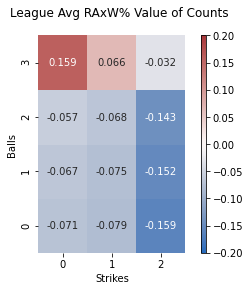

In [6]:
count_value = pd.DataFrame()

for random_team_str in os.listdir(path_home):
    year = random_team_str[:4]
    team = random_team_str[4:7]
    
    home_csv = pd.read_csv(path_home+random_team_str,index_col=[0,1])
    team_home = Team(team, year, home_csv, 1)
    
    outcome_at_count = team_home.outcomes.groupby('Count')['Outcome'].value_counts().unstack().fillna(0)[['K', 'O', 'W', 'S', 'D', 'T', 'R']]
    outcome_at_count = outcome_at_count.T[[0,10,20,30,1,11,21,31,2,12,22,32]].T
    outcome_frac = outcome_at_count.div(outcome_at_count.sum(axis=1),axis=0)
    outcome_frac.index = [j+i for i in ['0','1','2'] for j in ['0','1','2','3']]
    
    count_value = pd.concat([count_value, pd.DataFrame(outcome_frac.dot(lin_regr_home.coef_[:-1]),columns=[year+team]).T])
    
fig, ax = plt.subplots(1,2,figsize=(3,4),gridspec_kw=dict(width_ratios=[3,0.1]))
sns.heatmap(count_value.mean().to_numpy().reshape((3,4)).T,ax=ax[0],cmap = 'vlag',annot=True,fmt='.3f',cbar=False,vmin=-0.2,vmax=0.2)
plt.colorbar(ax[0].collections[0],cax=ax[1])
ax[0].invert_yaxis()
ax[0].set_xlabel('Strikes')
ax[0].set_ylabel('Balls')
fig.suptitle('League Avg RAxW% Value of Counts')
plt.show()

### Adding the influence of the pitcher to modified strategies

In order to address the second issue with the previous method, we need to add context to the pitches that batters are supposed to be patient with or aggressive towards.  The definition of being aggressive on some pitch count means swinging at more of the pitches, while being patient means swinging at less.  An aggressive strategy will reduce the number of balls and called strikes and increase balls-in-play, swinging strikes, and foul balls, and vice-versa for a patient strategy.

Before discussing exactly how different strategies change the number of each type of pitch and the outcomes, we construct the necessary functions to determine the predicted change in win percentage once the modifications are applied to the hitting strategy.  The method we will apply is a Markov Chain, transitioning between different pitch counts and at-bat outcomes.  The steady state solution reached when starting from a 0-0 pitch count will give the probabilities that each at-bat ends in the outcomes needed for the linear model above.

While an eigenvector analysis would often be used for finding the steady state of a Markov Chain, the directionality associated with traversing pitch counts renders this technique useless.  To see this, the stochastic matrix projects out the zero-pitch state (the 0-0 count) into some ball-in-play or a one-pitch state (either 0-1 or 1-0 count).  A second application of the matrix will project out the one-pitch states into either a ball-in-play or a two-pitch state (0-2, 1-1, or 2-0).  Given these successive projections, the only way some eigenvector has a non-zero component associated with the 0-0 count is if the transition probability ($\alpha$) to 1-pitch states is zero:

Assuming an eigenvector of the form $P = (P(00), P(1\text{-Pitch}), ...)^T,$

A single application of the transition matrix $\mathcal{S}$ projects out the 0-0 count, resulting in:
\begin{equation}
\mathcal{S}P = \lambda P = \lambda (0, \alpha P(00),...)^T.
\end{equation}

A second application of the transition matrix then projects out the one-pitch states, but since $P$ is an eigenvector, we have:
\begin{equation}
\lambda^2 (0, 0, ...)^T = \mathcal{S}^2P = \lambda \mathcal{S}P = \lambda^2 (0,\alpha P(00),...)^T,
\end{equation}
thus the transition between the zero-pitch and one-pitch states  $\alpha = 0$.  Since no team will always put the ball into play on the first pitch of every at-bat, the initial vector $(1, 0, 0,...)^T$ cannot be decomposed into eigenvalues.  Instead, the steady state solution can only be approximated by successive applications of the transition matrix.

In [7]:
# Given a team's change in strategy, modify the number of outcomes for each pitch in different counts.
def modify_count_outcomes(team_class, pitch_counts, swing_changes, count_outcomes):    
    mod_count_outcomes = pitch_counts[['B','C','S','X']].copy()
    
    # Assume hitters will not get hit-by-pitch more often
    mod_count_outcomes['B'] = pitch_counts['B'] - count_outcomes['H'] + swing_changes[['X>B','S>B','B>X','B>S']].dot(np.array([1,1,-1,-1]))
    mod_count_outcomes['H'] = count_outcomes['H']
    
    mod_count_outcomes['C'] = simple_pitch['C'] + swing_changes[['X>C','S>C','C>X','C>S']].dot(np.array([1,1,-1,-1]))
    mod_count_outcomes['S'] = simple_pitch['S'] + swing_changes[['C>S','B>S','S>B','S>C']].dot(np.array([1,1,-1,-1]))

    # Additional swings are not bunts, so no extra foul bunts (only relevant for strike 3 on foul bunt)
    mod_count_outcomes['X'] = simple_pitch['X']  - count_outcomes['L'] + swing_changes[['C>X','B>X','X>B','X>C']].dot(np.array([1,1,-1,-1]))
    mod_count_outcomes['L'] = count_outcomes['L']
    
    return contact_to_inplay(team_class, mod_count_outcomes, count_outcomes)


# Distinguish between different types of contact made; Fair vs Foul terrirory, out vs hit.
# Given a modified strategy, we assume the ratio of these events remains the same as the unmodified strategy.
def contact_to_inplay(team_class, mod_count_outcomes, old_count_outcomes):
    # Split contact made on the pitch into foul or fair territory using team data for each count
    # The remaining column of fair territory is labelled 'X' to split again
    pitch_contact_result = pd.concat([mod_count_outcomes.drop(columns=['X']),
                                      old_count_outcomes[['F','X']].div(old_count_outcomes[['F','X']].sum(axis=1),axis=0)*np.array([mod_count_outcomes['X'].values]).T],
                                     axis=1)
    pitch_contact_result = pitch_contact_result[['B','H','C','S','L','F','X']]
    pitch_contact_result.columns = ['Ball','HBP','CStrike','SStrike','FBunt', 'Foul','X']
    
    # Split the remaining pitches hit into play into their respective outcomes (Out, Single, Double, Triple, HR)
    inplay_outcomes = team_class.outcomes.groupby('Count')['Outcome'].value_counts().unstack().fillna(0)[['O','S','D','T','R']]
    inplay_outcomes.set_index(count_outcomes.index,inplace=True)
    inplay_outcomes.columns = ['Out','Single','Double','Triple','HR']
    
    return pd.concat([pitch_contact_result.drop(columns=['X']),
                    inplay_outcomes.div(inplay_outcomes.sum(axis=1),axis=0)*np.array([pitch_contact_result['X'].values]).T],
                    axis=1)


# Implements game rules for determining how one pitch count moves to another
def group_pitch_outcomes(count_outcomes):
    # Group which outcomes have the same result, depending on the pitch count
    grouped_outcomes = count_outcomes[['Out','Single','Double','Triple','HR']].copy()
    grouped_outcomes.loc[count_outcomes.index.str[0]=='3','Ball'] = 0
    grouped_outcomes.loc[count_outcomes.index.str[0]=='3','Walk'] = count_outcomes[['Ball','HBP']].sum(axis=1)
    grouped_outcomes.loc[count_outcomes.index.str[0]!='3','Ball'] = count_outcomes['Ball']
    grouped_outcomes.loc[count_outcomes.index.str[0]!='3','Walk'] = count_outcomes['HBP']
    grouped_outcomes.loc[count_outcomes.index.str[1]=='2','Strike'] = 0
    grouped_outcomes.loc[count_outcomes.index.str[1]=='2','Self'] = count_outcomes['Foul']
    grouped_outcomes.loc[count_outcomes.index.str[1]=='2','Strikeout'] = count_outcomes[['CStrike','SStrike','FBunt']].sum(axis=1)
    grouped_outcomes.loc[count_outcomes.index.str[1]!='2','Strike'] = count_outcomes[['CStrike','SStrike','FBunt','Foul']].sum(axis=1)
    grouped_outcomes.loc[count_outcomes.index.str[1]!='2','Self'] = 0
    grouped_outcomes.loc[count_outcomes.index.str[1]!='2','Strikeout'] = 0
    return grouped_outcomes


# Creates a stochastic matrix describing the transitions between different pitch counts and outcomes from a single pitch
def transformation_matrix(grouped_outcomes):
    outcome_labels = ['Strikeout','Out','Walk','Single','Double','Triple','HR']
    count_labels = grouped_outcomes.index.tolist()
    all_labels = count_labels+outcome_labels
    transition_matrix = pd.DataFrame(index=all_labels, columns=all_labels)
    
    # For each count (b,s), determine the number of times the count moves to (b,s), (b+1,s), and (b,s+1)
    for count in count_labels:
        b = int(count)//10
        s = int(count)%10
        transition_matrix.loc[count,count] = grouped_outcomes.loc[count,'Self']
        if s<2:
            transition_matrix.iloc[3*b+s, 3*b+s+1] = grouped_outcomes.loc[count,'Strike']
        if b<3:
            transition_matrix.iloc[3*b+s, 3*(b+1)+s] = grouped_outcomes.loc[count,'Ball']
            
    # Determine the number of times an at-bat ends with some outcome at each count
    for end_outcome in outcome_labels:
        transition_matrix[end_outcome] = grouped_outcomes[end_outcome]    
    transition_matrix.fillna(0,inplace=True)
    
    # Convert number of events at a particular count into percent chances to produce Markov Chain
    # When the at-bat ends, it cannot be started back up, so the outcomes of at-bats have extra conditions
    MC = transition_matrix.div(transition_matrix.sum(axis=1),axis=0).T
    for end_outcome in outcome_labels:
        MC.loc[:,end_outcome] = 0
        MC.loc[end_outcome, end_outcome] = 1
    return MC


# Approximate the steady state solution by sucessive application of the transition matrix
def steady_state(transition_matrix, initial_vector, iterations):
    v0 = initial_vector
    for _ in range(iterations):
        v0 = transition_matrix.dot(v0)
    return v0


# Modify a team's hitting strategy using the above functions.
# The function will return the average steady state outcomes of the team's total at-bats.
def strategy_mod(team_class, simple_pitch, swing_changes, count_outcomes):
    # Update number of pitch outcomes for the strategy, and split contact outcomes into fouls, outs, and the different hits
    mod_count_outcomes = modify_count_outcomes(team_class, simple_pitch, swing_changes, count_outcomes)
    
    # Add game logic and contrust stochastic matrix for transitions
    grouped_outcomes = group_pitch_outcomes(mod_count_outcomes)
    markov_chain = transformation_matrix(grouped_outcomes)
    
    # All at-bats start at the 0-0 count
    initial_vector = np.zeros(len(markov_chain.index))
    initial_vector[0] = 1
    # The longest at-bat in MLB history is 21 pitches.  To be safe, we look out to 25 pitch at-bats.
    # While there is non-zero probability that the at-bat continues, it's effect will be negligible at this point.
    outcomes_ss = steady_state(markov_chain, initial_vector, 25)

    # The resulting vector V represents the probability of each outcome,
    # We multiply by the total number of at-bats in the season to get the predicted number of each outcome
    total_ab = team_class.outcomes['Outcome'].value_counts().sum()
    return outcomes_ss[markov_chain.index[12:]]*total_ab

#### Additional Team Statistics

With the intent of redefining aggressive and patient strategies in terms of swinging or not swinging at different types of pitches, we will need to include data on how often a team swings (Swing%) and makes contact (Contact%) on pitches inside(Z) and outside(O) of the strike zone.

We briefly explain these statistics:

Zone%: Percentage of all pitches in the strike zone (would be called a strike with no swing)

O/Z-Swing%: Percentage of pitches inside(Z) or outside(O) the zone that are swung on

O/Z-Contact%: Percentage of swings on pitches inside(Z) or outside(O) where contact was made

Note, this data is only available for teams during the 2002 season onwards, so we cannot analyze earlier teams.  Furthermore, the data is not separated between home and away statistics or between pitch counts, which would be optimal for this analysis.

In [8]:
path_home = ''
path_away = ''

# Choose some team to modify the strategy
random_team_str = random.choice([file for file in os.listdir(path_home) if int(file[:4])>=2002])
year = random_team_str[:4]
team = random_team_str[4:7]

home_csv = pd.read_csv(path_home+random_team_str,index_col=[0,1])
away_csv = pd.read_csv(path_away+random_team_str[:-4]+'Away',index_col=[0,1])
team_home = Team(team, year, home_csv, 1)
team_away = Team(team, year, away_csv, 0)


# Load the team's plate discipline data
path_discipline = ''
year_discipline = pd.read_csv(path_discipline+year+".csv", index_col=[0])

# Data is a string in the form of a percent.  Convert this into float values
for col in year_discipline.columns:
    year_discipline[col] = year_discipline[col].str.rstrip('%').astype(float)/100

# Rename indices to match previous Team IDs
team_renames = {'CHC':'CHN','CHW':'CHA','FLA':'FLO','KCR':'KCA','LAA':'ANA','LAD':'LAN','NYM':'NYN','NYY':'NYA','SDP':'SDN','SFG':'SFN','STL':'SLN','TBR':'TBA','TBD':'TBA','WSN':'WAS'}
team_discipline = year_discipline.rename(team_renames).loc[team][['O-Swing%','O-Contact%','Z-Swing%','Z-Contact%','Zone%','Swing%','Contact%']]
display(team_discipline)

O-Swing%      0.223
O-Contact%    0.522
Z-Swing%      0.690
Z-Contact%    0.864
Zone%         0.509
Swing%        0.461
Contact%      0.783
Name: COL, dtype: float64

We need to calculate the probability that not swinging at certain pitches would have resulted in a strike or a ball, and whether swinging at balls or called strikes would result in contact or not.  The latter two are precisely the definition of Z/O-Contact.  The former would be easily calculable using Bayes Theorem, but without the zone, swing, and contact data for each count, the results will be heavily skewed.

Instead, we will use the at-bat level data available to find how often balls, called strikes, swinging strikes, and contact is made for each pitch count (even if it is not the terminal pitch count).

To lay out the problem, we would like to calculate the following quantities for each pitch count:

- The five plate discipline statistics listed above (Zone%, O/Z-Swing%, and O/Z-Contact%)

- Number of swinging strikes on pitches inside and outside of the strikes zone (label below as SZ and SO, respectively)

- Number of swings resulting in contact on pitches inside and outside of the strike zone (label below as XZ and XO, respectively)

However, we only have the definitions of the five stats as well as the total number of swinging strikes and pitches where contact was made.  Thus, we need to take seasonal stats for two of these unknown quantities and solve for the rest.

While some debate can be had for which stats should be held constant at the seasonal average, a natural choice is O/Z-Contact%.  Generally speaking, these stats shouldn't change much between different counts since hitters are always trying to hit the ball when they swing.

In [9]:
# Label each pitch during an at-bat
# Inside or outside of the strike zone or whether the batter swung at the pitch and made contact or missed.
# Some special cases are kept (hit-by-pitch and foul bunt), since they influence how the count of an at-bat progresses
all_pitch_types = 'IKMOPQRTV'
all_pitch_repl =  'BSSSBSFSB'
pitch_none = 'NU'

# Set whether you want to evaluate on home or away data
data = team_home

team_pitches = data.event_data['Pitches'].str.translate(str.maketrans(all_pitch_types,all_pitch_repl,pitch_none))
stacked_pitch = (team_pitches).str.split('', expand=True).stack()
stacked_pitch = stacked_pitch.drop(stacked_pitch[stacked_pitch==''].index)

# For each pitch during each at-bat, add the current pitch count
# Translating each pitch into an updated count is dealt with inside the Team class file
pitchs_and_counts = pd.concat([data.pitch_counts_during_ab(data.parsing_pitches()),stacked_pitch],axis=1)
pitchs_and_counts.columns = ['Count','Outcome']

# Collect all pitch labels for each count
count_outcomes = pitchs_and_counts.groupby('Count')['Outcome'].value_counts().unstack().fillna(0)[['B','H','C','S','L','F','X']]

# Group pitch labels, dropping special labels now that each count is correctly identified
simple_pitch = pd.DataFrame()
simple_pitch['B'] = count_outcomes['B']+count_outcomes['H'] # Pitches outside the strike zone w/o swing
simple_pitch['C'] = count_outcomes['C'] # Pitches inside the strike zone w/o swing
simple_pitch['S'] = count_outcomes['S'] # Pitches swung at w/o contact
simple_pitch['X'] = count_outcomes['X'] + count_outcomes['L'] + count_outcomes['F'] # Pitches swung at w/ contact
simple_pitch['Total'] = count_outcomes.sum(axis=1) # Total number of pitches thrown at a particular count

The simplest was to solve the system of equations is to look at the total swinging strikes, total number of pitches with contact made, and the definitions of Z/O-Contact%.  From Z/O-Contact%, we can solve:
\begin{equation}
X_i = S_i \left(\frac{\text{i-contact\%}}{1 - \text{i-contact\%}}\right),
\end{equation}
where $i=Z,O$ for inside or outside the strike zone.  Then, using the values of $S_Z, S_O$ can be solved by inverting the equation:
\begin{equation}
\begin{pmatrix}
S\\
X
\end{pmatrix}=
\begin{pmatrix}
1 & 1\\
\frac{\text{o-contact\%}}{1 - \text{o-contact\%}} & \frac{\text{z-contact\%}}{1 - \text{z-contact\%}}
\end{pmatrix}
\begin{pmatrix}
S_O\\
S_Z
\end{pmatrix}.
\end{equation}
With the separation between swings and contact inside and outside of the zone, simply applying the definition of Zone% and Z/O-Swing% gives us the remaining quantities.

In [10]:
# Solve for the values of SZ, SO
A = np.array([[1,1],[team_discipline['O-Contact%']/(1-team_discipline['O-Contact%']),team_discipline['Z-Contact%']/(1-team_discipline['Z-Contact%'])]])
simple_pitch_zosep = pd.concat([simple_pitch, simple_pitch[['S','X']].dot(np.linalg.inv(A).T)],axis=1).rename(columns={0:'SO',1:'SZ'})

# If SO is negative due to the approximation made with seasonal average, set it to zero and correct SZ.
simple_pitch_zosep.loc[(simple_pitch_zosep['SO']<0),'SZ'] = simple_pitch_zosep['SO'] + simple_pitch_zosep['SZ']
simple_pitch_zosep.loc[(simple_pitch_zosep['SO']<0),'SO'] = 0

# Calculate the split of X into Z/O
simple_pitch_zosep['XO'] = simple_pitch_zosep['SO']*team_discipline['O-Contact%']/(1-team_discipline['O-Contact%'])
simple_pitch_zosep['XZ'] = simple_pitch_zosep['SZ']*team_discipline['Z-Contact%']/(1-team_discipline['Z-Contact%'])
simple_pitch_zosep.loc[np.abs(simple_pitch_zosep[['XZ','XO']].sum(axis=1)<1E-5), 'XZ'] = simple_pitch_zosep['X']

# Calculate Z/O-Swing% and Zone%
simple_pitch_zosep['O-Swing%'] = simple_pitch_zosep[['XO','SO']].sum(axis=1)/simple_pitch_zosep[['B','XO','SO']].sum(axis=1)
simple_pitch_zosep['Z-Swing%'] = simple_pitch_zosep[['SZ','XZ']].sum(axis=1)/simple_pitch_zosep[['C','SZ','XZ']].sum(axis=1)
simple_pitch_zosep['Zone%'] = simple_pitch_zosep[['C','SZ','XZ']].sum(axis=1)/simple_pitch_zosep['Total']

simple_pitch_zosep['O-Contact%'] = team_discipline['O-Contact%']
simple_pitch_zosep['Z-Contact%'] = team_discipline['Z-Contact%']

display(simple_pitch_zosep)#[['Zone%','O-Swing%','Z-Swing%','O-Contact%','Z-Contact%']])

,B,C,S,X,Total,SO,SZ,XO,XZ,O-Swing%,Z-Swing%,Zone%,O-Contact%,Z-Contact%
Count,,,,,,,,,,,,,,
00,1324.0,882.0,175.0,779.0,3160.0,63.252538,1.117475e+02,69.074947,709.925053,0.090864,0.482295,0.539137,0.522,0.864
01,623.0,139.0,139.0,517.0,1418.0,69.581146,6.941885e+01,75.986105,441.013895,0.189401,0.785967,0.457992,0.522,0.864
02,272.0,26.0,74.0,225.0,597.0,46.592421,2.740758e+01,50.881263,174.118737,0.263818,0.885728,0.381116,0.522,0.864
10,495.0,280.0,96.0,449.0,1320.0,30.580819,6.541918e+01,33.395789,415.604211,0.114453,0.632074,0.576533,0.522,0.864
11,449.0,125.0,129.0,512.0,1215.0,58.455766,7.054423e+01,63.836632,448.163368,0.214063,0.805812,0.529800,0.522,0.864
12,389.0,33.0,121.0,488.0,1031.0,53.357099,6.764290e+01,58.268632,429.731368,0.222972,0.937780,0.514427,0.522,0.864
20,182.0,151.0,26.0,134.0,493.0,5.926082,2.007392e+01,6.471579,127.528421,0.063775,0.494311,0.605684,0.522,0.864
21,209.0,76.0,77.0,315.0,677.0,33.107789,4.389221e+01,36.155368,278.844632,0.248912,0.809398,0.588976,0.522,0.864
22,269.0,33.0,122.0,482.0,906.0,55.705170,6.629483e+01,60.832842,421.167158,0.302274,0.936595,0.574461,0.522,0.864


As a quick sanity check, we see that when the pitcher is ahead in the count (more balls than strikes), the Zone% drops since they are not incentivized to throw strikes and give the batter the advantage.  Similarly, when the batter is ahead, the O-Swing% decreases, since the batter does not need to chase bad pitchs.


### Redefining Patient and Aggressive Strategies

As previously mentioned, defining aggressive/patient modifications to a hitting strategy as simply the increase/decrease the number of at-bats ending at particular pitch counts ignores a large amount of nuance within hitting.  How much can the batter really do to avoid striking out when down 0-2 in the count?  If a batter is patient and just doesn't swing on the 0-2 pitch, are they really going to improve their chances of reaching bases?

A more straightforward way to address changes in hitting strategies is to change how often a team swings at different pitches in different counts.  We define an aggressive strategy as one that swings more frequently, converting balls and called strikes into swinging strikes and contact, during some particular pitch count.  Similarly, a patient strategy will be one that swings less frequently, converting these pitches in the opposite direction.

#### Taking an Aggressive Approach

In an aggressive approach, we can easily apply the Z/O-Contact% to the addtional called strikes/balls that are being swung at.  Importantly, we must include a systematic approach to decreasing both balls and called strikes, rather than simply telling a team to swing at called strikes and ignore balls.  Based on the count-specific statistics, we consider Bayes Theorem to calculate the probability of a pitch being inside or outside the strikezone if swung at:
\begin{equation}
P(Z|\text{Swing}) = \frac{\text{Zone%}}{\text{Swing%}}\times(\text{Z-Swing%}) = \frac{S_Z + X_Z}{S + X}\\
P(O|\text{Swing}) = \frac{1-\text{Zone%}}{\text{Swing%}}\times(\text{O-Swing%}) = \frac{S_O + X_O}{S + X}
\end{equation}
These give the fraction of additional swings which would be on balls or called strikes.  By definition, multiplying these probabilities by Z/O-Contact% will further split the additional swings at previous balls and called strikes into swinging strikes and contact.

Special attention when the number of extra pitches being swung at exceeds the number of balls or strikes from a particular pitch count.  When we expect to swing at a number of called strikes exceed the number that actually occurs, we attempt to make up the difference by pulling from the number of balls.  Once all the called strikes and balls are being swung at, we cannot swing at any more pitches, so we truncate the change.

In [11]:
def aggressive_modification(pitch_ZO_sep, count_outcomes, swing_per):
    # Conditional probabilities to determine the ratio of balls to called strikes
    pz_swing = pitch_ZO_sep['Zone%']/(pitch_ZO_sep[['S','X']].sum(axis=1)/pitch_ZO_sep['Total'])*pitch_ZO_sep['Z-Swing%']
    po_swing = (1-pitch_ZO_sep['Zone%'])/(pitch_ZO_sep[['S','X']].sum(axis=1)/pitch_ZO_sep['Total'])*pitch_ZO_sep['O-Swing%']

    # How many balls and called strikes will be swung at
    extra_swings = pd.concat([po_swing,pz_swing], axis=1).multiply(swing_per*pitch_ZO_sep['Total'],axis=0)
    extra_swings.columns = ['B', 'C']

    # If swinging at too many of one type of pitch, take the leftover number from the other type
    # If there are not enough total pitches available, do not take anymore.
    extra_swings.loc[(extra_swings['B'] > pitch_ZO_sep['B'])&(extra_swings['C'] > pitch_ZO_sep['C']),'C'] = pitch_ZO_sep['C']
    extra_swings.loc[(extra_swings['B'] > pitch_ZO_sep['B'])&(extra_swings['C'] > pitch_ZO_sep['C']),'B'] = pitch_ZO_sep['B']-count_outcomes['H']

    extra_swings.loc[(extra_swings['B'] > pitch_ZO_sep['B']+count_outcomes['H']),'C'] = np.minimum(pitch_ZO_sep['C'], extra_swings['C']+extra_swings['B']-pitch_ZO_sep['B']+count_outcomes['H'])
    extra_swings.loc[(extra_swings['B'] > pitch_ZO_sep['B']+count_outcomes['H']),'B'] = pitch_ZO_sep['B']-count_outcomes['H']

    extra_swings.loc[(extra_swings['C'] > pitch_ZO_sep['C']),'B'] = np.minimum(pitch_ZO_sep['B']-count_outcomes['H'], extra_swings['B']+extra_swings['C']-pitch_ZO_sep['C'])
    extra_swings.loc[(extra_swings['C'] > pitch_ZO_sep['C']),'C'] = pitch_ZO_sep['C']

    contact_array = np.array([pitch_ZO_sep.loc['00','O-Contact%'],pitch_ZO_sep.loc['00','Z-Contact%']])
    
    # Calculate how many of the extra swings will result in contact or not
    # Set the number of swinging strikes and contact converted into balls and called strikes to zero
    swing_contact = extra_swings*contact_array
    swing_nocontact = extra_swings*(1-contact_array)
    swing_contact.columns = ['B>X','C>X']
    swing_nocontact.columns = ['B>S','C>S']
    swing_changes = pd.concat([swing_contact, swing_nocontact],axis=1)
    swing_changes[['X>B','X>C','S>B','S>C']] = 0
    swing_changes.fillna(0,inplace=True)
    
    return swing_changes

#### Taking a Patient Approach

Similar to the Aggressive approach, we need to systematically choose pitches to not swing at.  Of the pitches not swung at, we keep the fraction of balls to called strikes constant.  Intuitively, when telling a batter to swing less frequently, the hitter must still make the decision which pitches are still worse to swing at.

\begin{equation}
P(Z|\text{No Swing}) = \frac{C}{C+B}\\
P(O|\text{No Swing}) = \frac{B}{C+B}
\end{equation}

The distribution of these pitches that are taken from the pitches where contact was or was not made is again controlled by the O/Z-Contact% for the team.

In [12]:
def patient_modification(pitch_ZO_sep, count_outcomes, swing_per):
    # Conditional probabilities to determine how many balls or called strikes will be added to each count.
    pz_noswing = pitch_ZO_sep['C']/pitch_ZO_sep[['B','C']].sum(axis=1)
    po_noswing = pitch_ZO_sep['B']/pitch_ZO_sep[['B','C']].sum(axis=1)
    
    # Convert probabilities to total pitches
    removed_swings = pd.concat([po_noswing,pz_noswing], axis=1).multiply(swing_per*pitch_ZO_sep['Total'],axis=0)
    removed_swings.columns = ['To B', 'To C']
    
    contact_array = np.array([pitch_ZO_sep.loc['00','O-Contact%'],pitch_ZO_sep.loc['00','Z-Contact%']])
    
    # Determine which pitches will be removed from contact or no contact swings
    removed_contact = removed_swings*contact_array
    removed_nocontact = removed_swings*(1-contact_array)
    removed_contact.columns = ['X>B','X>C']
    removed_nocontact.columns = ['S>B','S>C']
    swing_changes = pd.concat([removed_contact, removed_nocontact],axis=1)
    swing_changes[['B>X','C>X','B>S','C>S']] = 0
    swing_changes.fillna(0,inplace=True)
    
    # If total number of pitches to change exceed the number of pitches available, convert all available but no more
    swing_changes.loc[(removed_swings[['To B','To C']].sum(axis=1)>pitch_ZO_sep[['X','S']].sum(axis=1)+count_outcomes['L']),'X>B'] = pitch_ZO_sep['XO']
    swing_changes.loc[(removed_swings[['To B','To C']].sum(axis=1)>pitch_ZO_sep[['X','S']].sum(axis=1)+count_outcomes['L']),'X>C'] = pitch_ZO_sep['XZ'] - count_outcomes['L']
    swing_changes.loc[(removed_swings[['To B','To C']].sum(axis=1)>pitch_ZO_sep[['X','S']].sum(axis=1)+count_outcomes['L']),'S>B'] = pitch_ZO_sep['SO']
    swing_changes.loc[(removed_swings[['To B','To C']].sum(axis=1)>pitch_ZO_sep[['X','S']].sum(axis=1)+count_outcomes['L']),'S>C'] = pitch_ZO_sep['SZ']
    
    # Cannot convert Z and O pitches between one another
    # Ratio of Si/Xi pitches is controlled by the i-Contact%, as the split above, so both types are saturated simultaneously
    swing_changes.loc[(swing_changes[['X>B','S>B']].sum(axis=1) > pitch_ZO_sep[['SO','XO']].sum(axis=1)),'X>B'] = pitch_ZO_sep['XO']
    swing_changes.loc[(swing_changes[['X>B','S>B']].sum(axis=1) > pitch_ZO_sep[['SO','XO']].sum(axis=1)),'S>B'] = pitch_ZO_sep['SO']
    swing_changes.loc[(swing_changes[['X>C','S>C']].sum(axis=1) > pitch_ZO_sep[['SZ','XZ']].sum(axis=1)+count_outcomes['L']),'X>C'] = pitch_ZO_sep['XZ'] - count_outcomes['L']
    swing_changes.loc[(swing_changes[['X>C','S>C']].sum(axis=1) > pitch_ZO_sep[['SZ','XZ']].sum(axis=1)+count_outcomes['L']),'S>C'] = pitch_ZO_sep['SZ']

    return swing_changes

#### Combining Aggressive and Patient strategies

The above two functions to determine the aggressive or patient modifications to a team's strategy returns the number of changed pitches/outcomes from each pitch count over the course of a season.  For each count, one can apply either aggressive or patient changes of various magnitudes.

Unlike previous iterations of the strategy modifications, where the only sanity condition was that we change less than 100% of the number of at-bats ending at some count, here we must make sure we do not remove more individual pitch types than actually occur.  The types of modifications we are working are linear only until this saturation occurs, at which point a new linear behavior begins.  Some pitch count changes quickly saturate and trying to further modify these counts will often result in reduced effectiveness.

For now, we will look at modifying a single pitch count by either an aggressive or patient approach.  Note that aggressive and patient approaches are not easily related to one another, so we much check each modification for each count separately.

In [13]:
aggro_modifications = {}
patient_modifications = {}
percent_change = 0.01
aggro_swing_changes = aggressive_modification(simple_pitch_zosep, count_outcomes, percent_change)
patient_swing_changes = patient_modification(simple_pitch_zosep, count_outcomes, percent_change)


for count_to_change in ['None']+simple_pitch.index.tolist():
    aggro_swing_changes_cur_count = aggro_swing_changes.copy()
    aggro_swing_changes_cur_count.loc[aggro_swing_changes_cur_count.index!=count_to_change]=0
    
    patient_swing_changes_cur_count = patient_swing_changes.copy()
    patient_swing_changes_cur_count.loc[patient_swing_changes_cur_count.index!=count_to_change]=0
    
    aggro_modifications[count_to_change] = strategy_mod(data, simple_pitch, aggro_swing_changes_cur_count, count_outcomes)
    patient_modifications[count_to_change] = strategy_mod(data, simple_pitch, patient_swing_changes_cur_count, count_outcomes)

aggro_strategies = pd.DataFrame(aggro_modifications).T
aggro_strategies['RA'] = home_data.loc[(int(year), team)]['RA']
predicted_wins_aggro = lin_regr_home.predict(aggro_strategies)/aggro_strategies['RA']*81
net_pred_wins_aggro = predicted_wins_aggro-predicted_wins_aggro['None']

patient_strategies = pd.DataFrame(patient_modifications).T
patient_strategies['RA'] = home_data.loc[(int(year), team)]['RA']
predicted_wins_patient = lin_regr_home.predict(patient_strategies)/patient_strategies['RA']*81
net_pred_wins_patient = predicted_wins_patient-predicted_wins_patient['None']

net_pred_wins = pd.concat([net_pred_wins_aggro, net_pred_wins_patient],axis=1)
net_pred_wins.columns = ['Aggressive','Patient']

print('{} {} Home'.format(year,team))
print()
print('Optimal {} Aggressive Change \n Count: {}, Additional Wins: {:.2f}'.format(percent_change,net_pred_wins_aggro.index[np.argmax(net_pred_wins_aggro)],np.max(net_pred_wins_aggro)))
print()
print('Optimal {} Patient Change \n Count: {}, Additional Wins: {:.2f}'.format(percent_change,net_pred_wins_patient.index[np.argmax(net_pred_wins_patient)],np.max(net_pred_wins_patient)))
display(net_pred_wins.drop('None').T)

2003 COL Home

Optimal 0.01 Aggressive Change 
 Count: 32, Additional Wins: 0.17

Optimal 0.01 Patient Change 
 Count: 32, Additional Wins: 0.25


,00,01,02,10,11,12,20,21,22,30,31,32
Aggressive,0.053929,0.061234,0.074079,0.000714,0.025289,0.165582,-0.018598,-0.018314,0.154230,-0.005652,-0.019698,0.173659
Patient,0.094673,0.053239,0.042508,0.104755,0.085690,0.131308,0.075482,0.104501,0.188683,0.003034,0.082067,0.251553


We can look at how different percentage changes to a particular count will change the optimal strategy modification. Most modifications, both patient and aggressive, result in a increase in the team's strategy for small percentage changes.  This is likely due to the limitation of the model, specifically trying to extract count-specific plate discipline statistics using season averaged O/Z-Contact%.  Given the limitations of the data, this is likely the best statistic to hold constant, but it does end up heavily swaying how pitches are converted between one another.  For most teams, a swing results in contact more often than not, which is generally better than swinging and missing.  As a result, an aggressive approach will generally convert called strikes, one of the worst outcomes, into contact, one of the best.  Similarly, for a patient approach, swinging strikes will often be converted into balls.  As a result, it will likely be best to use modest values for the percentage change to calculate the improvement in a team's win percentage.

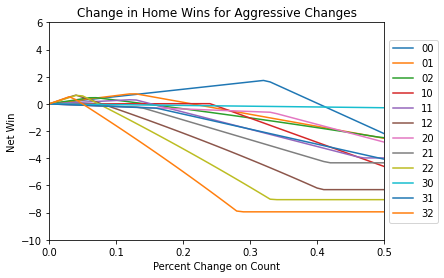

In [14]:
net_wins_at_count = pd.DataFrame()

for i in range(51):
    modifications = {}
    percent_change = i/100
    
    swing_changes = aggressive_modification(simple_pitch_zosep, count_outcomes, percent_change)

    for count_to_change in ['None']+simple_pitch.index.tolist():
        swing_changes_cur_count = swing_changes.copy()
        swing_changes_cur_count.loc[swing_changes_cur_count.index!=count_to_change]=0

        modifications[count_to_change] = strategy_mod(data,simple_pitch,swing_changes_cur_count,count_outcomes)
    strategies = pd.DataFrame(modifications).T
    strategies['RA'] = home_data.loc[(int(year), team)]['RA']
    predicted_wins = lin_regr_home.predict(strategies)/strategies['RA']*81
    net_pred_wins = predicted_wins - predicted_wins['None']
    net_wins_at_count = pd.concat([net_wins_at_count,net_pred_wins.drop('None')],axis=1).rename(columns={'RA':percent_change})
    
net_wins_at_count.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlim(0,0.5)
plt.ylim(-10,6)
plt.title('Change in Home Wins for Aggressive Changes')
plt.xlabel('Percent Change on Count')
plt.ylabel('Net Win')
plt.show()